Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/04_Classification'
except ImportError as e:
    pass

## Exercise 4: Classification

### 4.1. Who should get a bank credit?
The German credit data set from the UCI data set library (http://archive.ics.uci.edu/ml/index.html) describes the customers of a bank with respect to whether they should get a bank credit or not. The data set is provided as credit-g.arff file in ILIAS. 

#### 4.1.1.	Plot ROC curves for k-NN (different k values), Logistic Regression and Naïve Bayes classification (you can use the given avg_roc function). Which classification approach looks most promising to you?

In [3]:
import pandas as pd
from scipy.io import arff
credit_arff_data, credit_arff_meta = arff.loadarff(open('credit-g.arff', 'r'))
credit = pd.DataFrame(credit_arff_data)
# select all columns of type object
columns_with_binary_strings = credit.select_dtypes('object').columns.values

# decode the values of these columns using utf-8
credit[columns_with_binary_strings] = credit[columns_with_binary_strings].apply(lambda x: x.str.decode("utf-8"))
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


First define the preprocessing. Have a look at the class distribution and feature types and think about appropriate transformations.

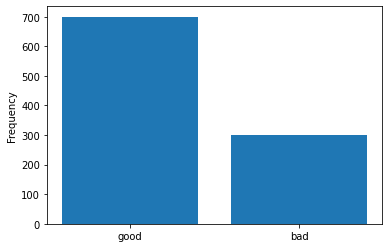

In [4]:
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# separate the target variable from the features
credit_target = credit['class']
credit_data = credit.drop('class', axis=1)

# plot the class distribution
class_dist = pd.Series(credit_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# list all numerical features that we want to re-scale
numeric_features = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['credit_history', 'purpose', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])

# list all ordinal features that we want to encode using OrdinalEncoder
ordinal_features = [ 'checking_status', 'savings_status', 'employment', 'own_telephone', 'foreign_worker']
ordinal_transformer = Pipeline([ ('ordinal', OrdinalEncoder()) ])

# define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

display(preprocessor.fit_transform(credit_data))

array([[-1.23647786, -0.74513141,  0.91847717, ...,  3.        ,
         1.        ,  1.        ],
       [ 2.24819436,  0.94981679, -0.87018333, ...,  0.        ,
         0.        ,  1.        ],
       [-0.73866754, -0.41656241, -0.87018333, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.73866754, -0.87450324,  0.91847717, ...,  3.        ,
         0.        ,  1.        ],
       [ 1.9992892 , -0.50552769,  0.91847717, ...,  0.        ,
         1.        ,  1.        ],
       [ 1.9992892 ,  0.46245715,  0.02414692, ...,  4.        ,
         0.        ,  1.        ]])

Run the following cell once to define the ```avg_roc``` function:

In [6]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from numpy import interp
from sklearn.metrics import roc_curve, auc

# Input values:
# cv = cross validatoin (Object) f.e. StratifiedKFold
# estimator = esimator, pieline (not fitted jet)
#(no split jet):
# data
# target 
# pos_label (which is positive Class? not ecoded: "positive")


def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data.iloc[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)#have to use predict_proba or decision_function 
    
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

Evaluate different classifiers using the ```avg_roc``` function and plot the results:

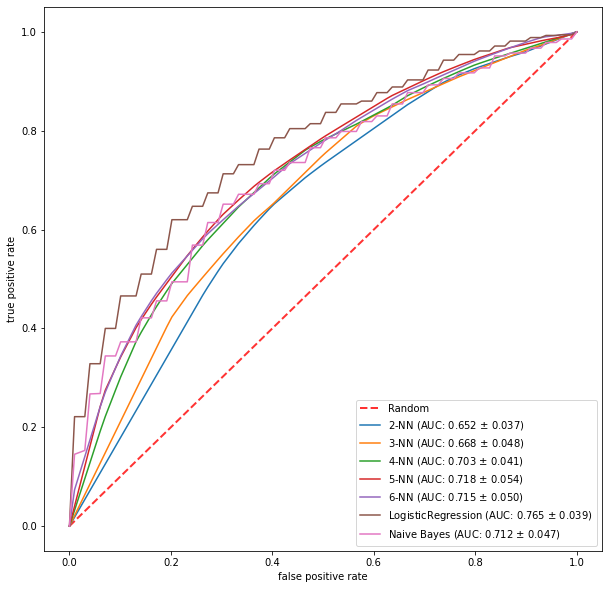

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', None) ])

# setup a figure
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8) # draw diagonal

# KNN
pipeline.set_params(estimator=KNeighborsClassifier())
for n_neighbour in [2,3,4,5,6]:
    pipeline.set_params(estimator__n_neighbors=n_neighbour)
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data, credit_target, 'good')
    plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))
    
# Decision Tree
pipeline.set_params(estimator=LogisticRegression(max_iter=200))
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data, credit_target, 'good')
plt.plot(mean_fpr, mean_tpr, label='LogisticRegression (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

# Naive Bayes
pipeline.set_params(estimator=GaussianNB())
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, credit_data, credit_target, 'good')
plt.plot(mean_fpr, mean_tpr, label='Naive Bayes (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

# show the plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

#### 4.1.2.	For the two most promising classification approaches, compute the accuracy and confusion matrix in a 10-fold CV setup. Which level of accuracy do you reach?

In [8]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

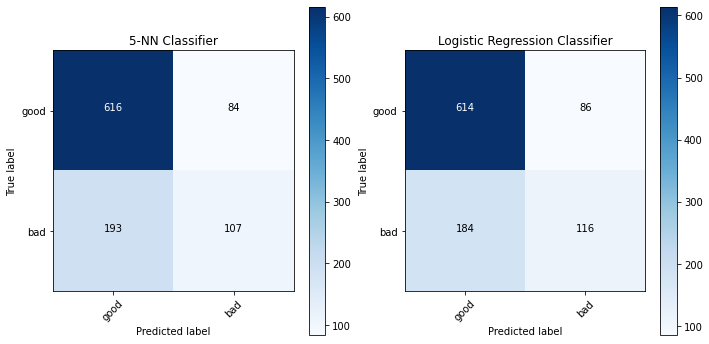

Classification Report for 5-NN Classifier:
              precision    recall  f1-score   support

         bad       0.56      0.36      0.44       300
        good       0.76      0.88      0.82       700

    accuracy                           0.72      1000
   macro avg       0.66      0.62      0.63      1000
weighted avg       0.70      0.72      0.70      1000

Classification Report for Logistic Regression Classifier:
              precision    recall  f1-score   support

         bad       0.57      0.39      0.46       300
        good       0.77      0.88      0.82       700

    accuracy                           0.73      1000
   macro avg       0.67      0.63      0.64      1000
weighted avg       0.71      0.73      0.71      1000



In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.figure(figsize=(10,5))

classes = credit_target.unique()

# KNN
plt.subplot(1,2,1)
pipeline.set_params(estimator=KNeighborsClassifier(5))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)
cnf_matrix = confusion_matrix(credit_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='5-NN Classifier')
rep_knn = classification_report(credit_target, prediction)

# LogisticRegression
plt.subplot(1,2,2)
pipeline.set_params(estimator=LogisticRegression(max_iter=200))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)
cnf_matrix = confusion_matrix(credit_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Logistic Regression Classifier')
rep_regression = classification_report(credit_target, prediction)

plt.show()

print("Classification Report for 5-NN Classifier:")
print(rep_knn)

print("Classification Report for Logistic Regression Classifier:")
print(rep_regression)

#### 4.1.3.	What do the precision and recall values for the class “bad”  tell you? Try to improve the situation by increasing the number of “bad” examples in the training set (in the cross validation). How do precision and recall change if you apply this procedure? 

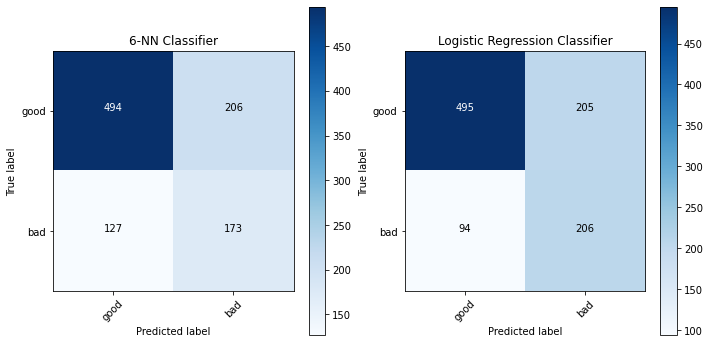

Classification Report for 5-NN Classifier:
              precision    recall  f1-score   support

         bad       0.46      0.58      0.51       300
        good       0.80      0.71      0.75       700

    accuracy                           0.67      1000
   macro avg       0.63      0.64      0.63      1000
weighted avg       0.69      0.67      0.68      1000

Classification Report for Logistic Regression Classifier:
              precision    recall  f1-score   support

         bad       0.50      0.69      0.58       300
        good       0.84      0.71      0.77       700

    accuracy                           0.70      1000
   macro avg       0.67      0.70      0.67      1000
weighted avg       0.74      0.70      0.71      1000



In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# create a new pipeline with balancing
pipeline = Pipeline([ ('preprocessing', preprocessor), ('balancing', RandomOverSampler()), ('estimator', None) ])

plt.figure(figsize=(10,5))

classes = credit_target.unique()

# KNN
plt.subplot(1,2,1)
pipeline.set_params(estimator=KNeighborsClassifier(5))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)
cnf_matrix = confusion_matrix(credit_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='6-NN Classifier')
rep_knn = classification_report(credit_target, prediction)

# LogisticRegression
plt.subplot(1,2,2)
pipeline.set_params(estimator=LogisticRegression(max_iter=200))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)
cnf_matrix = confusion_matrix(credit_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Logistic Regression Classifier')
rep_regression = classification_report(credit_target, prediction)

plt.show()

print("Classification Report for 5-NN Classifier:")
print(rep_knn)

print("Classification Report for Logistic Regression Classifier:")
print(rep_regression)

#### 4.1.4.	To model a use case specific evaluation, compute the cost of all missclassifications. Set up your cost matrix by assuming that you will lose 1 Unit if you refuse a credit to a good customer, but that you lose 100 Units if you give a bad customer a credit. Rerun the experiments and evaluate the results.

In [22]:
pipeline.set_params(estimator=KNeighborsClassifier(5))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(credit_target, prediction, labels=credit_target.unique())
cost = cm[1][0] * 100 + cm[0][1] * 1
acc = accuracy_score(credit_target, prediction)

print("5-NN with accuracy of {} and cost {}".format(acc, cost))

5-NN with accuracy of 0.654 and cost 12523


In [23]:
pipeline.set_params(estimator=LogisticRegression(max_iter=200))
prediction = cross_val_predict(pipeline, credit_data, credit_target, cv=cv)

cm = confusion_matrix(credit_target, prediction, labels=credit_target.unique())
cost = cm[1][0] * 100 + cm[0][1] * 1
acc = accuracy_score(credit_target, prediction)

print("Logistic Regression with accuracy of {} and cost {}".format(acc, cost))

Logistic Regression with accuracy of 0.698 and cost 10004


#### 4.1.5.	As the creation of training data is mostly a manual task and humans tend to be fallible, training data might include noise. Simulate this behavior by using the Add Noise function and change the parameter “percentage” from 0% over 10% to 20%. Is your preferred classification approach still feasible for this situation? How does the performance of the other classifiers evolve?

In [24]:
import random 
from sklearn.utils.multiclass import unique_labels
def add_noise(raw_target, percentage):    
    labels = unique_labels(raw_target)
    target_with_noise = []
    for one_target_label in raw_target:
        if random.randint(1,100) <= percentage:
            target_with_noise.append(next(l for l in labels if l != one_target_label))
        else:
            target_with_noise.append(one_target_label)
    return target_with_noise

In [25]:
for estimator in [KNeighborsClassifier(5), LogisticRegression(max_iter=200)]:
    for noise in [0,10,20, 30]:    
        all_test_target = []
        all_test_predition = []
        for train_indices, test_indices in cv.split(credit_data, credit_target):
            train_data, train_target = credit_data.iloc[train_indices], credit_target[train_indices]
            test_data, test_target = credit_data.iloc[test_indices], credit_target[test_indices]

            train_target = add_noise(train_target, noise)  
            pipeline.set_params(estimator=estimator)
            pipeline.fit(train_data, train_target)

            test_prediction = pipeline.predict(test_data)

            all_test_target.extend(test_target)
            all_test_predition.extend(test_prediction)
    
        print("estimator {} with {} % noise : {} accuracy".format(
            str(estimator).split("(", 1)[0], 
            noise, 
            accuracy_score(all_test_target, all_test_predition)))

estimator KNeighborsClassifier with 0 % noise : 0.653 accuracy
estimator KNeighborsClassifier with 10 % noise : 0.609 accuracy
estimator KNeighborsClassifier with 20 % noise : 0.612 accuracy
estimator KNeighborsClassifier with 30 % noise : 0.566 accuracy
estimator LogisticRegression with 0 % noise : 0.696 accuracy
estimator LogisticRegression with 10 % noise : 0.675 accuracy
estimator LogisticRegression with 20 % noise : 0.663 accuracy
estimator LogisticRegression with 30 % noise : 0.638 accuracy


### 4.2. Open Competition: Finding rich Americans
The Adult data set from the UCI data set library (http://archive.ics.uci.edu/ml/datasets/Adult) describes 48842 persons from the 1994 US Census. The data set is provided as adult.arff file on the website of this course. 

Your task is to find a good classifier for determining whether a person earns over 50.000 $ 
a year. Beside of being accurate, your classifier should also have balanced precision and recall.

To evaluate your classifiers use train_test_split validation (test_size=0.2, random_state=42).
In order to find the best classifier, you may experiment with:
1.	different algorithms
2.	different parameter settings
3.	the balance of the two classes in the data set
4.	the set of attributes that are used or not used
5.	other preprocessing techniques

In order to increase your understanding of the data set, you might want to visualize different attributes or attribute combinations.

In [28]:
adult_arff_data, adult_arff_meta = arff.loadarff(open('adult.arff', 'r'))
adult = pd.DataFrame(adult_arff_data)
adult = adult.applymap(lambda x: x.decode('utf8').replace("'", "") if hasattr(x, 'decode') else x)

adult_target = np.array(adult['class'])
adult_data = adult.drop('class', axis=1)
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States


In [29]:
# Create train/test split
from sklearn.model_selection import train_test_split
adult_data_train, adult_data_test, adult_target_train, adult_target_test = train_test_split(
    adult_data, adult_target, test_size=0.2, random_state=42)

First, define a ColumnTransformer to handle the preprocessing:

In [31]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')) ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', None) ])

Then, test a couple of classification methods as baseline:

In [1]:
adult_target_train

NameError: name 'adult_target_train' is not defined

LogisticRegression
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     29676
        >50K       0.73      0.60      0.66      9397

    accuracy                           0.85     39073
   macro avg       0.81      0.77      0.78     39073
weighted avg       0.84      0.85      0.85     39073

KNeighborsClassifier
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89     29676
        >50K       0.68      0.60      0.64      9397

    accuracy                           0.83     39073
   macro avg       0.78      0.75      0.76     39073
weighted avg       0.83      0.83      0.83     39073

GaussianNB
              precision    recall  f1-score   support

       <=50K       0.96      0.52      0.67     29676
        >50K       0.38      0.93      0.54      9397

    accuracy                           0.62     39073
   macro avg       0.67      0.72      0.61     39073
weighted avg       0.82

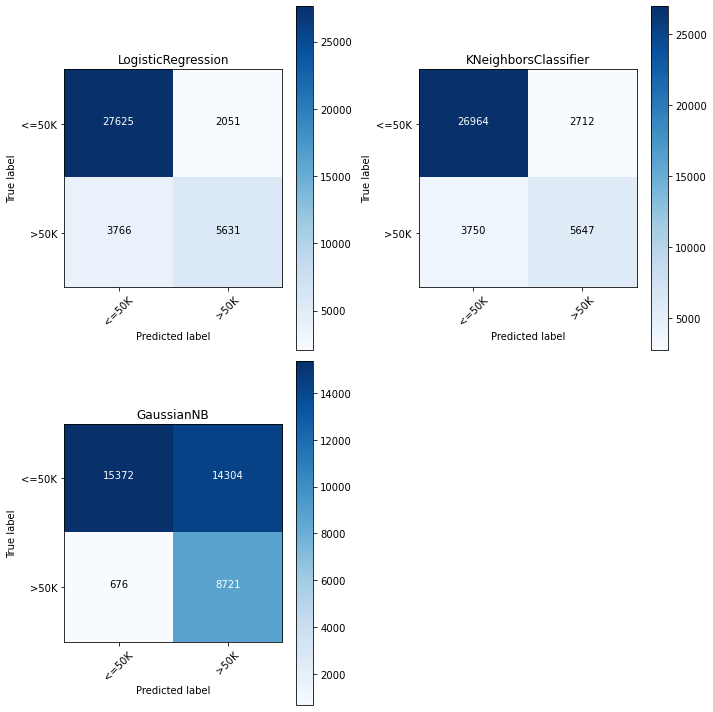

In [32]:
estimators = [
    LogisticRegression(), KNeighborsClassifier(), GaussianNB()
]

plt.figure(figsize=(10,10))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, estimator in enumerate(estimators):
    plt.subplot(2,2,i+1)
    pipeline.set_params(estimator=estimator)
    prediction = cross_val_predict(pipeline, adult_data_train, adult_target_train, cv=cv, n_jobs=-1)
    cm = confusion_matrix(adult_target_train, prediction)
    plot_confusion_matrix(cm, classes=unique_labels(adult_target_train), title=type(estimator).__name__)
    print(type(estimator).__name__)
    print(classification_report(adult_target_train, prediction))
    
plt.show()

Have a look at the class distribution:

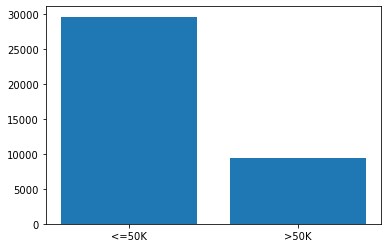

In [33]:
class_dist = pd.Series(adult_target_train).value_counts()
plt.bar(class_dist.index, class_dist)
plt.show()

The classes are imbalanced, so we try balancing and a grid search over the hyper-parameters to try and improve our classifiers.
We also define a score (F1-measure) to use for the grid search, as accuracy can be misleading for imbalanced datasets.

In [41]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([ ('preprocessing', preprocessor), ('balancing', RandomUnderSampler()), ('estimator', LogisticRegression()) ])

parameters = {
    'estimator__C':[ 0.0001, 0.1, 100],
    #'estimator__solver':[ 'newton-cg', 'lbfgs', 'saga'], # comment in for more parameter optimization
    #'estimator__penalty' :['l1', 'l2']
}

# define the scoring function
f1 = make_scorer(f1_score, pos_label='>50K')

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1)

grid_search_estimator.fit(adult_data_train, adult_target_train)

print("Logistic Regression: {}% F1-score for class '>50K' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

Logistic Regression: 67.90320341249783% F1-score for class '>50K' with parameters {'estimator__C': 0.1}


Optimise parameters for K-NN:

In [42]:
pipeline.set_params(estimator=KNeighborsClassifier())

grid_search_estimator.param_grid = {
    'estimator__n_neighbors': [ 2, 3, 4]
}

grid_search_estimator.fit(adult_data_train, adult_target_train)

print("K-NN: {}% F1-score for class '>50K' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

KeyboardInterrupt: 

Select the best model based on cross validated scores on the training set, then evaluate it on the test set:

              precision    recall  f1-score   support

       <=50K       0.92      0.83      0.87      7479
        >50K       0.57      0.75      0.65      2290

    accuracy                           0.81      9769
   macro avg       0.75      0.79      0.76      9769
weighted avg       0.84      0.81      0.82      9769



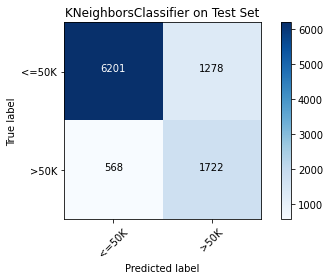

In [17]:
# configure the pipeline to use the best estimator and hyper-parameters based on the training set
pipeline.set_params(estimator=KNeighborsClassifier())
pipeline.set_params(estimator__n_neighbors=4)
pipeline.fit(adult_data_train, adult_target_train)

# evaluate the pipeline on the test set to get an estimate of the accuracy on unseen data
prediction = pipeline.predict(adult_data_test)
cm = confusion_matrix(adult_target_test, prediction)
plot_confusion_matrix(cm, classes=unique_labels(adult_target_test), title="KNeighborsClassifier on Test Set")
print(classification_report(adult_target_test, prediction))